# LAB 3.1 — Lane Geometry Estimation from Bird’s-Eye-View Mask
ACE Lane-Keeping System – Geometry Module  
---

## 1. Overview
This lab covers the **core geometric computations** that convert a binary lane mask (from BEV) into:

- Lateral offset of the vehicle (`pos_m`)
- Heading deviation (`head_deg`)
- Multi-ratio sampling across the lane
- Adaptive selection of the most reliable ratio

These outputs form the **input to the Adaptive Lane Controller** used in LAB 3.3.


## 2. Learning Objectives

After this lab, learner will understand:

1. How to compute lane center from BEV mask  
2. How to estimate heading using two vertical sampling points  
3. How to convert pixel width → real-world meters  
4. How multi-ratio improves robustness  
5. How to evaluate stability using windowed statistics  


## 3. Import Libraries


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import deque

## 4. Load BEV Mask (Input from LAB 2)

In real deployment, this mask is generated from:

mask01 → ROI → morphology → BEV

For this lab, we load a sample BEV binary mask.

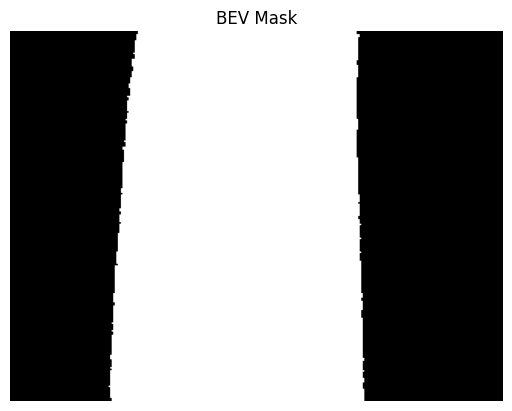

In [5]:
bev = cv2.imread(r"C:\Users\admin\ACE_Finalv3\debug_pipeline_out\frame_00600_4_bev.png", cv2.IMREAD_GRAYSCALE)
bev = (bev > 0).astype(np.uint8)

plt.imshow(bev, cmap='gray')
plt.title("BEV Mask")
plt.axis('off')
plt.show()


## 5. Compute Lane Width Scaling (meters_per_pixel)

To convert pixel distances into meters, we estimate lane width from the bottom row:

$$
meters\_per\_pixel = \frac{lane\_width\_m}{lane\_width\_px}
$$

We assume the physical lane width is **0.20 m** (Autocar-Kit specification).


In [6]:
def meters_per_pixel(bev, lane_width_m=0.20):
    H, W = bev.shape
    row = bev[H - 1, :]
    xs = np.where(row > 0)[0]

    if xs.size >= 2:
        width_px = float(xs[-1] - xs[0])
        width_px = max(width_px, 16.0)
        return lane_width_m / width_px
    
    return lane_width_m / max(W, 1)


## 6. Compute Lane Center at a Given Ratio

We sample the BEV mask horizontally at vertical position:

$$
y = ratio \cdot H
$$

Lane center = midpoint between left and right lane boundaries.


In [7]:
def center_x(bev, ratio):
    H, W = bev.shape
    y = int(ratio * H)
    y = np.clip(y, 0, H - 1)

    xs = np.where(bev[y, :] > 0)[0]
    if xs.size < 2:
        return np.nan
    
    return 0.5 * (xs[0] + xs[-1])


## 7. Compute Heading Angle

Heading is estimated using geometric slope between two points:

$$
dx = x_{bottom} - x_{top}
$$
$$
dy = pixel\_distance
$$
$$
heading = \arctan2(dx, dy)
$$

This approximates lane curvature in front of the camera.


In [8]:
def heading_deg_at_ratio(bev, ratio, dy_px=30):
    H, W = bev.shape

    yb = int(ratio * H)
    yt = max(0, yb - dy_px)

    xb = center_x(bev, ratio)
    xu = center_x(bev, yt / H)

    if np.isnan(xb) or np.isnan(xu):
        return np.nan, np.nan

    dx = xb - xu
    dy = (yb - yt) + 1e-6
    heading = np.degrees(np.arctan2(dx, dy))

    return float(heading), float(xb)


## 8. Multi-Ratio Sampling

Single-point sampling is noisy.  
Instead, we sample multiple vertical heights:

[0.98, 0.92, 0.82, 0.72]


For each ratio, we compute:
- `pos_m` : lateral offset  
- `head_deg` : heading  




In [9]:
ratios = [0.98, 0.92, 0.82, 0.72]
xm = meters_per_pixel(bev)

pos_list = []
head_list = []
cx_list = []

for r in ratios:
    head_deg, cx = heading_deg_at_ratio(bev, r)
    pos_m = (bev.shape[1] / 2 - cx) * xm

    pos_list.append(pos_m)
    head_list.append(head_deg)
    cx_list.append(cx)

print("Lateral offsets (m):", pos_list)
print("Headings (deg):", head_list)
print("Centers (px):", cx_list)


Lateral offsets (m): [0.015950920245398775, 0.015950920245398775, 0.015337423312883437, 0.015337423312883437]
Headings (deg): [0.0, -0.9548412220500405, 0.0, -0.9548412220500405]
Centers (px): [147.0, 147.0, 147.5, 147.5]


## 9. Adaptive Ratio Selection

We evaluate each ratio using:

$$
score = \frac{W\_STAB}{|pos|} - W\_HEAD |head| - W\_LAT(1-r)
$$

Higher score = more stable and reliable.

Constants: 

W_STAB = 2.0
W_HEAD = 0.1
W_LAT = 0.05



In [10]:
W_STAB, W_HEAD, W_LAT = 2.0, 0.1, 0.05

def select_best_ratio(pos_list, head_list, ratios):
    best = None
    best_i = 0
    for i, r in enumerate(ratios):
        p = pos_list[i]
        h = head_list[i]

        if np.isnan(p) or np.isnan(h):
            continue

        score = (W_STAB / (abs(p) + 1e-6) - W_HEAD * abs(h)) - W_LAT * (1 - r)

        if best is None or score > best:
            best = score
            best_i = i
    return best_i


In [11]:
best_idx = select_best_ratio(pos_list, head_list, ratios)

print("Best Ratio      :", ratios[best_idx])
print("Selected pos_m  :", pos_list[best_idx])
print("Selected head   :", head_list[best_idx])


Best Ratio      : 0.82
Selected pos_m  : 0.015337423312883437
Selected head   : 0.0


## 10. Visualization of Multi-Ratio Lane Centers


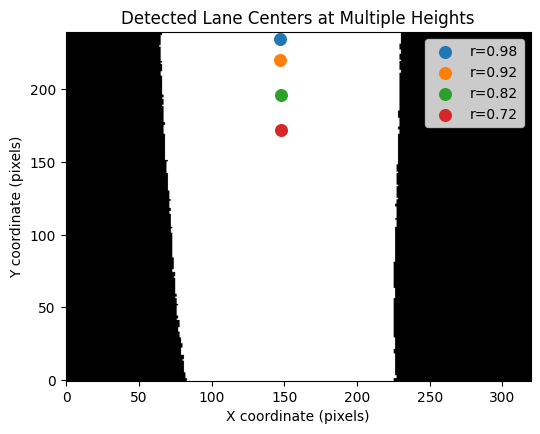

In [16]:

plt.figure(figsize=(6,6))

# Hiển thị BEV (mask 0/1 thành 0/255 cho dễ nhìn)
plt.imshow(bev * 255, cmap='gray', origin='upper')

H = bev.shape[0]

for i, cx in enumerate(cx_list):
    if not np.isnan(cx):
        y = int(ratios[i] * H)
        plt.scatter(cx, y, s=70, label=f"r={ratios[i]:.2f}")

plt.title("Detected Lane Centers at Multiple Heights")
plt.legend(loc="upper right")

# --- Quan trọng: đảo trục y để giống BEV thật của pipeline ---
plt.gca().invert_yaxis()

plt.xlabel("X coordinate (pixels)")
plt.ylabel("Y coordinate (pixels)")
plt.show()


## 11. Summary

In this lab, you implemented:

- Lane width estimation in meters  
- Center extraction from BEV mask  
- Heading estimation using slope geometry  
- Multi-ratio sampling  
- Adaptive selection of the best ratio  

These outputs feed directly into:

**LAB 3.2 – Temporal Stability & EMA Filtering**  
**LAB 3.3 – Adaptive Steering Control + Video Demo**
